# Validation and Regularization

![](images/hair.png)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## PART 1: Reading in and sampling from the data

In [53]:
df=pd.read_csv("data/noisypopulation.csv")
df.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


In [54]:
x=df.f.values
f=df.x.values
y = df.y.values

In [55]:
df.shape

(200, 3)

From 200 points on this curve, we'll make a random choice of 120 points. We do it by choosing the indexes randomly, and then using these indexes as a way of grtting the appropriate samples

In [56]:
indexes=np.sort(np.random.choice(x.shape[0], size=120, replace=False))
indexes

array([  1,   3,   4,   6,   7,   9,  10,  11,  13,  15,  16,  17,  18,
        19,  22,  23,  24,  25,  27,  28,  29,  31,  32,  34,  35,  36,
        37,  38,  39,  41,  42,  43,  46,  48,  50,  51,  53,  54,  55,
        58,  59,  60,  61,  69,  71,  73,  76,  78,  80,  82,  83,  86,
        88,  89,  90,  92,  94,  95,  97, 100, 101, 102, 103, 105, 106,
       107, 108, 109, 112, 114, 117, 118, 119, 121, 124, 125, 126, 127,
       128, 131, 132, 133, 135, 136, 137, 143, 144, 146, 147, 150, 152,
       153, 155, 160, 161, 162, 163, 164, 166, 168, 169, 170, 174, 178,
       179, 180, 182, 183, 184, 185, 186, 188, 192, 193, 194, 195, 196,
       197, 198, 199])

In [57]:
samplex = x[indexes]
samplef = f[indexes]
sampley = y[indexes]

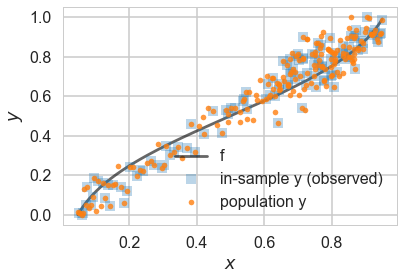

In [58]:
plt.plot(x,f, 'k-', alpha=0.6, label="f");
plt.plot(x[indexes], y[indexes], 's', alpha=0.3, ms=10, label="in-sample y (observed)");
plt.plot(x, y, '.', alpha=0.8, label="population y");
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.legend(loc=4);

In [59]:
sample_df=pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes]))

## Part 2: Fit on training set and predict on test set

We will do the split of testing and training for you in order to illustrate how this can be done.

### Train-test split

In [60]:
from sklearn.model_selection import train_test_split
datasize=sample_df.shape[0]
print(datasize)
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(np.arange(120),train_size=0.8)
print(itrain.shape)
xtrain= sample_df.x[itrain].values
ftrain = sample_df.f[itrain].values
ytrain = sample_df.y[itrain].values
xtest= sample_df.x[itest].values
ftest = sample_df.f[itest].values
ytest = sample_df.y[itest].values

120
(96,)


### Creating Polynomial features

We'll write a function to encapsulate what we learnt about creating the polynomial features.

In [61]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def make_features(train_set, test_set, degrees):
    train_dict = {}
    test_dict = {}
    for d in degrees:
        traintestdict={}
        train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        test_dict[d] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
    return train_dict, test_dict

## Cross Validation

1. You should worry that a given split exposes us to the peculiarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.
2. The multiple splits process also allows us to get an estimate of how consistent our prediction error is: in other words, just like in the hair example, it gives us a distribution.
3. Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible. But the smaller the validation set is, the more data we have to train our model on. This allows us to have more smaller sets

The idea is illustrated in the figure below, for a given hypothesis set $\cal{H}_a$ with complexity parameter $d=a$ (the polynomial degree). We do the train/validate split, not once but multiple times. 

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denoted as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![m:caption](images/train-cv2.png)

Note that the number of folds is equal to the number of splits in the data. For example, if we have 5 splits, there will be 5 folds. To illustrate cross-validation consider below fits in $\cal{H}_0$ and $\cal{H}_1$ (means and straight lines) to a sine curve, with only 3 data points.

### The entire description of K-fold Cross-validation

We put thogether this scheme to calculate the error for a given polynomial degree $d$ with the method we used earlier to choose a model given the validation-set risk as a function of $d$:

1. create `n_folds` partitions of the training data. 
2. We then train on `n_folds -1` of these partitions, and test on the remaining partition. There are `n_folds` such combinations of partitions (or folds), and thus we obtain `n_fold` risks.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{dCV}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

![caption](images/train-cv3.png)

It can also shown that **cross-validation error is an unbiased estimate of the out of sample-error**.

Let us now do 4-fold cross-validation on our  data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the remaining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we did what we did before: find the hypothesis space $\cal{H}_*$ with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

We will use `KFold` from `scikit-learn`:

In [62]:
from sklearn.model_selection import KFold
n_folds=4
kfold = KFold(n_folds)
list(kfold.split(range(48)))

[(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]), array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]), array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35]), array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]))]

What is wrong with the above? Why must we do the below?

In [63]:
kfold = KFold(n_folds, shuffle=True)
list(kfold.split(range(48)))

[(array([ 0,  1,  2,  3,  6,  7,  8,  9, 10, 11, 13, 14, 15, 17, 19, 20, 21,
         22, 23, 25, 26, 27, 30, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44,
         45, 46]), array([ 4,  5, 12, 16, 18, 24, 28, 29, 31, 37, 38, 47])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7, 12, 13, 14, 15, 16, 17, 18, 20, 21,
         22, 23, 24, 26, 28, 29, 31, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45,
         46, 47]), array([ 8,  9, 10, 11, 19, 25, 27, 30, 32, 33, 35, 42])),
 (array([ 3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21,
         24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 41, 42, 43, 44,
         45, 47]), array([ 0,  1,  2,  7, 17, 22, 23, 26, 34, 39, 40, 46])),
 (array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 12, 16, 17, 18, 19, 22, 23,
         24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42,
         46, 47]), array([ 3,  6, 13, 14, 15, 20, 21, 36, 41, 43, 44, 45]))]

In [64]:
for train, valid in kfold.split(range(48)):
    print("TRAIN INDICES", train)
    print("VALID INDICES", valid)
    print("VALID VALUES", xtrain[valid])

TRAIN INDICES [ 0  1  2  3  5  6  8 10 11 12 13 14 15 16 17 18 19 21 23 24 25 26 27 28 29
 30 32 34 35 36 38 39 42 43 46 47]
VALID INDICES [ 4  7  9 20 22 31 33 37 40 41 44 45]
VALID VALUES [ 0.66847716  0.76481781  0.54481073  0.65574675  0.91924334  0.67525289
  0.83314465  0.70177752  0.05119945  0.86433394  0.9331928   0.5       ]
TRAIN INDICES [ 0  3  4  5  6  7  8  9 10 12 14 15 17 20 21 22 23 24 25 26 27 30 31 33 34
 36 37 38 39 40 41 43 44 45 46 47]
VALID INDICES [ 1  2 11 13 16 18 19 28 29 32 35 42]
VALID VALUES [ 0.64299524  0.88493033  0.81585708  0.13566606  0.53982784  0.93740313
  0.48670439  0.8695251   0.75315202  0.15072397  0.29690143  0.89202872]
TRAIN INDICES [ 1  2  3  4  5  6  7  8  9 11 13 15 16 17 18 19 20 21 22 23 25 27 28 29 31
 32 33 34 35 37 39 40 41 42 44 45]
VALID INDICES [ 0 10 12 14 24 26 30 36 38 43 46 47]
VALID VALUES [ 0.89127429  0.7260675   0.77836014  0.32036919  0.76954353  0.71359101
  0.85662853  0.263258    0.66761369  0.7716579   0.69146246  0

### 4-fold CV on our data set

>YOUR TURN HERE: Carry out 4-Fold validation. For each fold, you will need to first create the polynomial features. for each degree polynomial, fit on the smaller training set and predict on the validation set. Store the MSEs, for each degree and each fold, in `train_errors` and `valid_errors`.

In [65]:
n_folds=4
degrees=range(21)
train_errors = np.zeros((21,4))
valid_errors = np.zeros((21,4))

In [66]:
# your code here
fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(96)): # split data into train/test groups, 4 times
    train_dict, valid_dict = make_features(xtrain[train], xtrain[valid], degrees)
    for d in degrees:
        est = LinearRegression()
        est.fit(train_dict[d], ytrain[train]) # fit
        train_errors[d, fold] = mean_squared_error(ytrain[train], est.predict(train_dict[d])) # evaluate score function on held-out data
        valid_errors[d, fold] = mean_squared_error(ytrain[valid], est.predict(valid_dict[d])) # evaluate score function on held-out data
    fold += 1

We average the MSEs over the folds

In [67]:
mean_train_errors = train_errors.mean(axis=1)
mean_valid_errors = valid_errors.mean(axis=1)
std_train_errors = train_errors.std(axis=1)
std_valid_errors = valid_errors.std(axis=1)

We find the degree that minimizes the `cross-validation` error, and just like before, refit the model on the entire training set

6


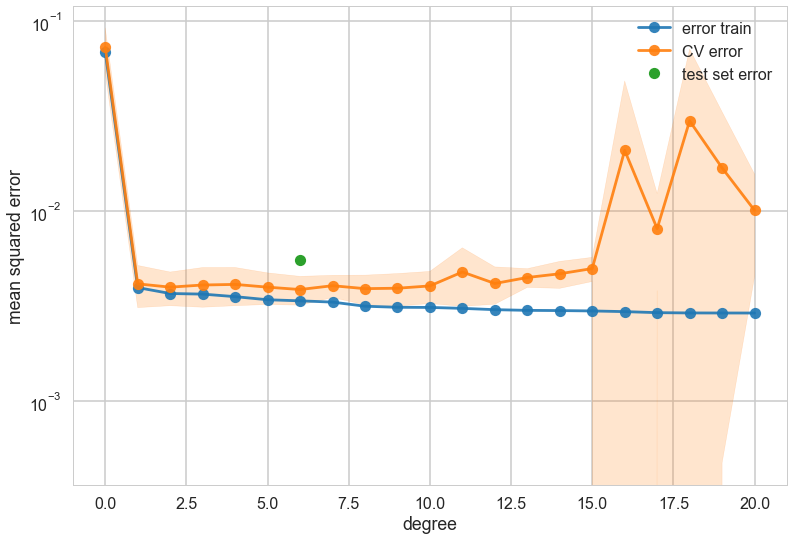

In [68]:
mindeg = np.argmin(mean_valid_errors)
print(mindeg)
post_cv_train_dict, test_dict=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
est = LinearRegression()
est.fit(post_cv_train_dict[mindeg], ytrain) # fit
pred = est.predict(test_dict[mindeg])
err = mean_squared_error(pred, ytest)
errtr=mean_squared_error(ytrain, est.predict(post_cv_train_dict[mindeg]))
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
with sns.plotting_context('poster'):
    plt.plot(degrees, mean_train_errors, marker='o', label='error train', alpha=0.9)
    plt.plot(degrees, mean_valid_errors, marker='o', label='CV error', alpha=0.9)


    plt.fill_between(degrees, mean_valid_errors-std_valid_errors, mean_valid_errors+std_valid_errors, color=c1, alpha=0.2)


    plt.plot([mindeg], [err], 'o',  label='test set error')

    plt.ylabel('mean squared error')
    plt.xlabel('degree')
    plt.legend(loc='upper right')
    plt.yscale('log')

We see that the cross-validation error minimizes at a low degree, and then increases. Because we have so few data points the spread in fold errors increases as well.

## Regularization

Upto now we have focussed on finding the polynomial with the right degree of complecity $d=*$ given the data that we have.

When we **regularize** we smooth or restrict the choices of the kinds of 20th order polynomials that we allow in our fits. 

That is, if we want to fit with a 20th order polynomial, ok, lets fit with it, but lets reduce the size of, or limit the functions in $\cal{H}_{20}$ that we allow.


We do this by a **soft constraint** by setting:

$$\sum_{i=0}^j a_i^2 < C.$$

This setting is called the Ridge.

This ensures that the coefficients dont get too high, which makes sure we dont get wildly behaving pilynomials with high coefficients. 

It turns out that we can do this by adding a term to the risk that we minimize on the training data for $\cal{H}_j$ (seeing why is beyond the scope here but google on lagrange multipliers and the dual problem):

$$\cal{R}(h_j) =  \sum_{y_i \in \cal{D}} (y_i - h_j(x_i))^2 +\alpha \sum_{i=0}^j a_i^2.$$

### Regularization of our model with Cross-Validation

In [69]:
def plot_functions(d, est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", ms=5, alpha=0.3)
    ax.plot(xtest, ytest, 's', label="testing", ms=5, alpha=0.3)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(d).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX),  '.', ms=7, alpha=0.8, label="alpha = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')
    
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')

The addition of a penalty term to the risk or error causes us to choose a smaller subset of the entire set of complex $\cal{H}_{20}$ polynomials. This is shown in the diagram below where the balance between bias and variance occurs at some subset $S_*$ of the set of 20th order polynomials indexed by $\alpha_*$ (there is an error on the diagram, the 13 there should actually be a 20).

![m:caption](images/complexity-error-reg.png)

Lets see what some of the $\alpha$s do. The diagram below trains on the entire training set, for given values of $\alpha$, minimizing the penalty-term-added training error.

**Note that here we are doing the note so good thing of exhausting the test set for demonstration purposes**

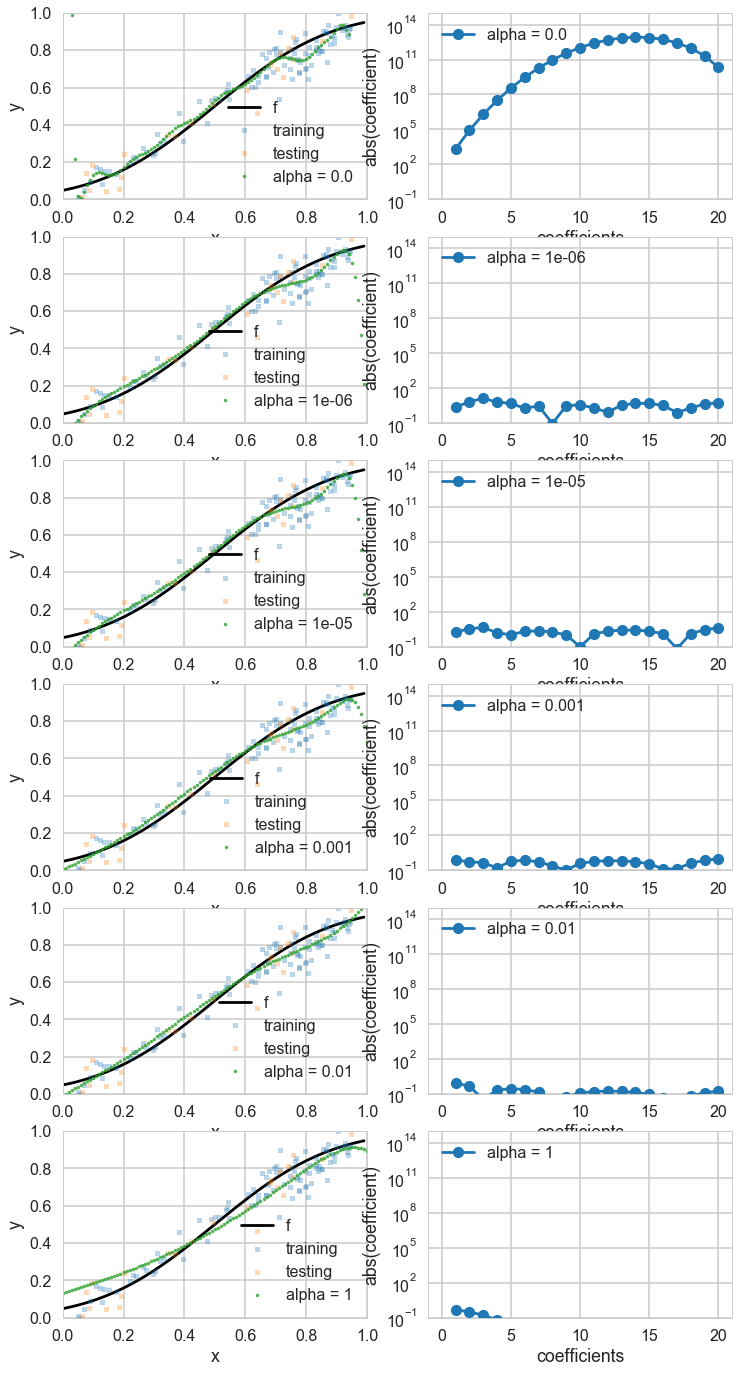

In [70]:
from sklearn.linear_model import Ridge
fig, rows = plt.subplots(6, 2, figsize=(12, 24))
d=20
alphas = [0.0, 1e-6, 1e-5, 1e-3, 0.01, 1]
train_dict, test_dict = make_features(xtrain, xtest, degrees)
Xtrain = train_dict[d]
Xtest = test_dict[d]
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(d, est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

As you can see, as we increase $\alpha$ from 0 to 1, we start out overfitting, then doing well, and then, our fits, develop a mind of their own irrespective of data, as the penalty term dominates the risk.

### `GridSearchCV` meta-estimator

Lets use cross-validation to figure what this critical $\alpha_*$ is. To do this we use the concept of a *meta-estimator* from scikit-learn. As the API paper puts it:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    est = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(est, param_grid=parameters, cv=4, scoring="mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over thefolds using `KFolds` and the averaging we did previously, doing it all for us. It takes a parameter grid in the shape of a dictionary as input, and sets $\alpha$ to the appropriate parameter values one by one. It then trains the model, cross-validation fashion, and gets the error. Finally it compares the errors for the different $\alpha$'s, and picks the best choice model.

In [71]:
from sklearn.model_selection import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    est = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(est, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error")
    gs.fit(X, y)
    return gs

In [72]:
fitmodel = cv_optimize_ridge(Xtrain, ytrain, n_folds=4)

In [73]:
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_

(Ridge(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 {'alpha': 1e-05},
 -0.0035625023434149362)

In [74]:
fitmodel.cv_results_

{'mean_fit_time': array([ 0.00078052,  0.00076526,  0.00051981,  0.00057995,  0.00069267,
         0.0009315 ,  0.00051105,  0.00065756,  0.00065827,  0.00048816]),
 'mean_score_time': array([ 0.0002349 ,  0.0002113 ,  0.00016522,  0.00020421,  0.00022101,
         0.0002811 ,  0.00016505,  0.00019979,  0.00017971,  0.00017029]),
 'mean_test_score': array([-0.00356783, -0.00358258, -0.0035625 , -0.00356461, -0.00358284,
        -0.00365149, -0.00367412, -0.00372607, -0.00388521, -0.00618897]),
 'mean_train_score': array([-0.00314285, -0.00322264, -0.003233  , -0.00325104, -0.00327311,
        -0.00334997, -0.00338338, -0.00351006, -0.00377346, -0.00600865]),
 'param_alpha': masked_array(data = [1e-08 1e-06 1e-05 5e-05 0.0001 0.0005 0.001 0.01 0.1 1.0],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'params': ({'alpha': 1e-08},
  {'alpha': 1e-06},
  {'alpha': 1e-05},
  {'alpha': 5e-05},
  {'alpha': 0.0001},
  {'alpha': 0.000

Our best model occurs for $\alpha=0.01$. We also output the mean cross-validation error at different $\alpha$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

### Refitting on entire training set

We refit the estimator on old training set, and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.


>YOUR TURN NOW: assign to variable est the classifier obtained by fitting the entire training set using the best $\alpha$ found above.

In [76]:
#Store in est a new classifier fit on the entire training set with the best alpha
#your code here
alphawechoose = fitmodel.best_params_['alpha']
est = Ridge(alpha=alphawechoose).fit(Xtrain,ytrain)

In [77]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

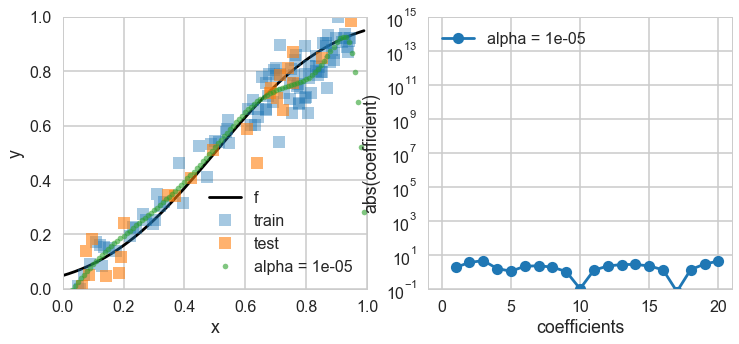

In [78]:
fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r=rows
plot_functions_onall(est, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(est, r, alphawechoose)

As we can see, the best fit model is now chosen from the entire set of 20th order polynomials, and a non-zero hyperparameter $\alpha$ that we fit for ensures that only smooth models amonst these polynomials are chosen, by setting most of the polynomial coefficients to something close to 0 (Lasson sets them exactly to 0).


> YOUR TURN NOW

>Try 2 experiments. Repeat the whole notebook with 60 chosen points. Why do we seem to need a larger alpha than before? In the non-regularized part, why id the estimated d smaller? Finally, compare the $\alpha$ obtained on the validation set against the informal $\alpha$ we obtained on the test set a bit above...